# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`. The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

In [1]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(400,'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89')

In [3]:
#Importing the Requisite Libraries
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import dates
import datetime as dt
import numpy as np

In [4]:

#Reading the Input File
df = pd.read_csv('data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv')

In [5]:
#Data Pre- Processing
df_processed = df.set_index(['ID', 'Date','Element']).unstack('Element').reset_index()
df_processed.columns = df.columns.get_level_values(0)
df_processed.rename(columns={'Element':'TMAX','Data_Value':'TMIN'},inplace= True)
print (df_processed.columns)
df_processed['Year']=[d.split('-')[0] for d in df_processed.Date]
df_processed['Month']=[d.split('-')[1] for d in df_processed.Date]
df_processed['Day']=[d.split('-')[2] for d in df_processed.Date]

Index(['ID', 'Date', 'TMAX', 'TMIN'], dtype='object')


In [6]:
#Getting the max and min Datewise for the period 2005-2014 and 2015 separately in different dataframes

# For 2015
df_2015 = df_processed[df_processed['Date'].str.contains("2015")]
df_2015_grp = df_2015.groupby(['Month','Day']).agg({'TMAX':'max','TMIN':'min'}).reset_index()

# For the period 2005-2014
df_2005_2014 =  df_processed[~df_processed['Date'].str.contains("2015")]

#Outlier Removal (Feb -29)
df_2005_2014 = df_2005_2014[~df_2005_2014['Date'].str.contains("02-29")]
df_rest_grp = df_2005_2014.groupby(['Month','Day']).agg({'TMAX':'max','TMIN':'min' ,'Date':'max'}).reset_index()

#Checking for the Total records
print ("\nTotal Records  in 2005-2014: %d \n"%(len(df_rest_grp)))
print ("\nTotal Records in 2015: %d \n"%(len(df_2015_grp)))

df_rest_grp['Day_of_Year'] = df_rest_grp.index+1


Total Records  in 2005-2014: 365 


Total Records in 2015: 365 



In [7]:
#Identifying the dates for which the min or max record was broken in 2015
df_2015_record = df_rest_grp.merge(df_2015_grp , on =['Month','Day'])
df_2015_record.rename(columns ={'TMAX_x':'TMAX_historical','TMIN_x':'TMIN_historical','TMAX_y':'TMAX_2015','TMIN_y':'TMIN_2015'},inplace=True)
df_2015_record_a =df_2015_record.query('TMAX_2015>TMAX_historical')[['Month','Day','Date','Day_of_Year','TMAX_2015']].rename(columns={'TMAX_2015':'Record'})
df_2015_record_b =df_2015_record.query('TMIN_2015<TMIN_historical')[['Month','Day','Date','Day_of_Year','TMIN_2015']].rename(columns={'TMIN_2015':'Record'})
df_2015 = pd.concat([df_2015_record_a,df_2015_record_b])


<IPython.core.display.Javascript object>


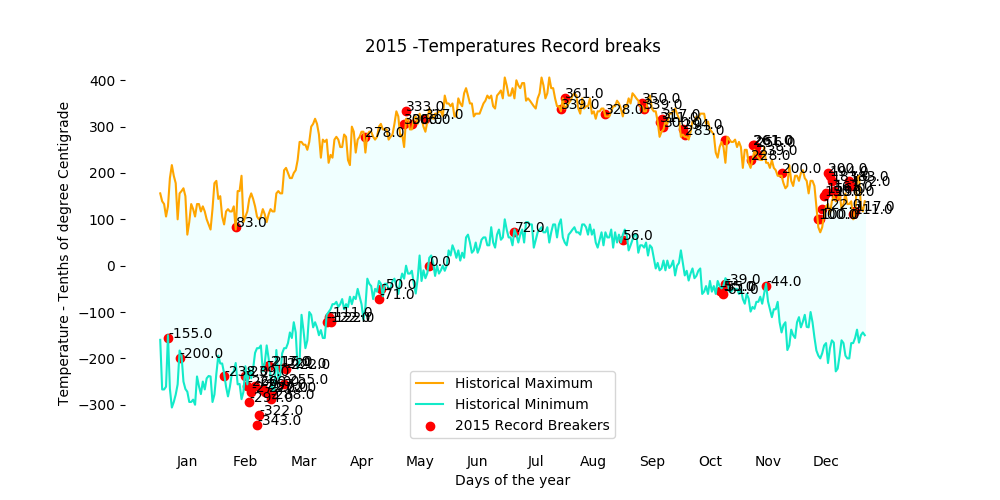

In [20]:
#Plotting the line graph for the subset
plt.figure(figsize= (10,5))
plt.plot(df_rest_grp.Day_of_Year,df_rest_grp.TMAX, color = 'orange',label = 'Historical Maximum')
plt.plot(df_rest_grp.Day_of_Year,df_rest_grp.TMIN, color = 'xkcd:aqua',label = 'Historical Minimum')
plt.fill_between(df_rest_grp.Day_of_Year,df_rest_grp.TMAX,df_rest_grp.TMIN, color = 'azure')
plt.xticks( np.linspace(15,15 + 30*11 , num = 12), (r'Jan', r'Feb', r'Mar', r'Apr', r'May', r'Jun', r'Jul', r'Aug', r'Sep', r'Oct', r'Nov', r'Dec') )
plt.xlabel("Days of the year")
plt.ylabel("Temperature - Tenths of degree Centigrade")
plt.title("2015 -Temperatures Record breaks")
plt.tick_params(top='off', bottom='off', left='on', right='off', labelleft='on', labelbottom='on')

#Removing the frame
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.scatter(df_2015.Day_of_Year,df_2015.Record,color = 'red',label ="2015 Record Breakers")
plt.legend()
### Annotating the Scatter points
#Day_record_dict =  dict(zip(df_2015.Day_of_Year,df_2015.Record))
#for k,v in Day_record_dict.items():
#    plt.annotate(v,(k,v))
    